# Julia is fast

Very often, benchmarks are used to compare languages.  These benchmarks can lead to long discussions, first as to exactly what is being benchmarked and secondly what explains the differences.  These simple questions can sometimes get more complicated than you at first might imagine.

The purpose of this notebook is for you to see a simple benchmark for yourself.  One can read the notebook and see what happened on the author's Macbook Pro with a 4-core Intel Core I7, or run the notebook yourself.

(This material began life as a wonderful lecture by Steven Johnson at MIT: https://github.com/stevengj/18S096/blob/master/lectures/lecture1/Boxes-and-registers.ipynb.)

# Outline of this notebook

- Define the sum function
- Implementations & benchmarking of sum in...
    - C (hand-written)
    - C (hand-written with -ffast-math)
    - python (built-in)
    - python (numpy)
    - python (hand-written)
    - Julia (built-in)
    - Julia (hand-written)
    - Julia (hand-written with SIMD)
- Summary of benchmarks

# `sum`: An easy enough function to understand

Consider the  **sum** function `sum(a)`, which computes
$$
\mathrm{sum}(a) = \sum_{i=1}^n a_i,
$$
where $n$ is the length of `a`.

In [1]:
a = rand(10^7) # 1D vector of random numbers, uniform on [0,1)

10000000-element Vector{Float64}:
 0.32869701596197043
 0.9216340195337122
 0.49208343437644264
 0.2344089883063486
 0.8476941624932173
 0.2080047720128757
 0.024506907602569683
 0.6859102022651173
 0.5206322429801868
 0.06203806611128604
 ⋮
 0.45221419158836595
 0.6707395402742419
 0.8677885154098488
 0.29716973177440487
 0.6262093449138764
 0.8852636998144761
 0.1539753990025008
 0.9669250064792458
 0.7113896324758077

In [3]:
sum(a)

4.999427650656363e6

The expected result is 0.5 * 10^7, since the mean of each entry is 0.5

# Benchmarking a few ways in a few languages

In [4]:
@time sum(a)

  0.007510 seconds (1 allocation: 16 bytes)


4.999427650656363e6

In [5]:
@time sum(a)

  0.007327 seconds (1 allocation: 16 bytes)


4.999427650656363e6

In [6]:
@time sum(a)

  0.006709 seconds (1 allocation: 16 bytes)


4.999427650656363e6

The `@time` macro can yield noisy results, so it's not our best choice for benchmarking!

Luckily, Julia has a `BenchmarkTools.jl` package to make benchmarking easy and accurate:

In [7]:
using Pkg
Pkg.add("BenchmarkTools")

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
   Installed BenchmarkTools ─ v1.3.1
    Updating `~/.julia/environments/v1.7/Project.toml`
  [6e4b80f9] + BenchmarkTools v1.3.1
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [6e4b80f9] + BenchmarkTools v1.3.1
  [9abbd945] + Profile
Precompiling project...
  ✓ BenchmarkTools
  1 dependency successfully precompiled in 2 seconds (152 already precompiled)


In [8]:
using BenchmarkTools  

#  1. The C language

C is often considered the gold standard: difficult on the human, nice for the machine. Getting within a factor of 2 of C is often satisfying. Nonetheless, even within C, there are many kinds of optimizations possible that a naive C writer may or may not get the advantage of.

The current author does not speak C, so he does not read the cell below, but is happy to know that you can put C code in a Julia session, compile it, and run it. Note that the `"""` wrap a multi-line string.

In [9]:
using Libdl
C_code = """
#include <stddef.h>
double c_sum(size_t n, double *X) {
    double s = 0.0;
    for (size_t i = 0; i < n; ++i) {
        s += X[i];
    }
    return s;
}
"""

const Clib = tempname()   # make a temporary file


# compile to a shared library by piping C_code to gcc
# (works only if you have gcc installed):

open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum(X::Array{Float64}) = ccall(("c_sum", Clib), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum (generic function with 1 method)

In [10]:
c_sum(a)

4.999427650656588e6

In [11]:
c_sum(a) ≈ sum(a) # type \approx and then <TAB> to get the ≈ symbolb

true

In [12]:
c_sum(a) - sum(a)  

2.253800630569458e-7

In [13]:
≈  # alias for the `isapprox` function

isapprox (generic function with 9 methods)

In [15]:
?isapprox

ErrorException: syntax: invalid identifier name "?"

We can now benchmark the C code directly from Julia:

In [16]:
c_bench = @benchmark c_sum($a)

BenchmarkTools.Trial: 297 samples with 1 evaluation.
 Range (min … max):  15.001 ms … 28.063 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     15.862 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   16.855 ms ±  2.386 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▄▃▄▄▃█ ▆                                                     
  ████████▆▅▃▃▂▂▄▂▃▂▂▂▃▂▁▂▂▃▂▁▁▃▄▃▁▃▃▃▁▁▃▃▄▃▂▁▃▃▂▃▃▂▃▁▂▁▁▂▁▂▃ ▃
  15 ms           Histogram: frequency by time        24.1 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [17]:
println("C: Fastest time was $(minimum(c_bench.times) / 1e6) msec")

C: Fastest time was 15.000608 msec


In [18]:
d = Dict()  # a "dictionary", i.e. an associative array
d["C"] = minimum(c_bench.times) / 1e6  # in milliseconds
d

Dict{Any, Any} with 1 entry:
  "C" => 15.0006

In [19]:
using Plots
gr()

Plots.GRBackend()

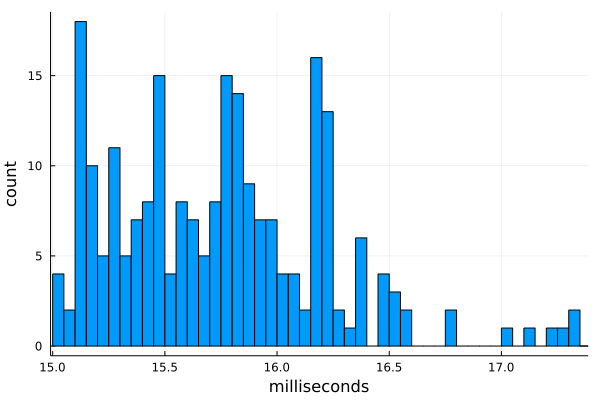

In [20]:
using Statistics # bring in statistical support for standard deviations
t = c_bench.times / 1e6 # times in milliseconds
m, σ = minimum(t), std(t)

histogram(t, bins=500,
    xlim=(m - 0.01, m + σ),
    xlabel="milliseconds", ylabel="count", label="")

# 2. C with -ffast-math

If we allow C to re-arrange the floating point operations, then it'll vectorize with SIMD (single instruction, multiple data) instructions.

In [21]:
const Clib_fastmath = tempname()   # make a temporary file

# The same as above but with a -ffast-math flag added
open(`gcc -fPIC -O3 -msse3 -xc -shared -ffast-math -o $(Clib_fastmath * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code) 
end

# define a Julia function that calls the C function:
c_sum_fastmath(X::Array{Float64}) = ccall(("c_sum", Clib_fastmath), Float64, (Csize_t, Ptr{Float64}), length(X), X)

c_sum_fastmath (generic function with 1 method)

In [22]:
c_fastmath_bench = @benchmark $c_sum_fastmath($a)

BenchmarkTools.Trial: 527 samples with 1 evaluation.
 Range (min … max):  9.119 ms …  10.342 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     9.445 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   9.477 ms ± 266.664 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ██▆         ▁ ▁  ▁                                         
  ▇▆███▇▄▆▃▆▇▇▇▇█▇██▇█▆▇▅▇█▆▇▇▅▅▅▅▄▅▄▃▃▄▄▂▄▃▃▃▃▃▃▂▃▂▃▃▃▁▂▁▂▁▂ ▄
  9.12 ms         Histogram: frequency by time        10.3 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [23]:
d["C -ffast-math"] = minimum(c_fastmath_bench.times) / 1e6  # in milliseconds

9.119009

# 3. Python's built in `sum` 

The `PyCall` package provides a Julia interface to Python:

In [24]:
using Pkg; Pkg.add("PyCall")
using PyCall

   Resolving package versions...
   Installed PyCall ─ v1.93.1
    Updating `~/.julia/environments/v1.7/Project.toml`
  [438e738f] + PyCall v1.93.1
    Updating `~/.julia/environments/v1.7/Manifest.toml`
  [438e738f] + PyCall v1.93.1
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/1fc929f47d7c151c839c5fc1375929766fb8edcc/build.log`
Precompiling project...
  ✓ PyCall
  1 dependency successfully precompiled in 6 seconds (153 already precompiled)


In [25]:
# get the Python built-in "sum" function:
pysum = pybuiltin("sum")

PyObject <built-in function sum>

In [26]:
pysum(a)

4.999427650656588e6

In [27]:
pysum(a) ≈ sum(a)

true

In [28]:
py_list_bench = @benchmark $pysum($a)

BenchmarkTools.Trial: 6 samples with 1 evaluation.
 Range (min … max):  835.393 ms … 877.840 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     848.842 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   852.705 ms ±  15.521 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █        █     █      █                 █                   █  
  █▁▁▁▁▁▁▁▁█▁▁▁▁▁█▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  835 ms           Histogram: frequency by time          878 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [29]:
d["Python built-in"] = minimum(py_list_bench.times) / 1e6
d

Dict{Any, Any} with 3 entries:
  "C"               => 15.0006
  "Python built-in" => 835.393
  "C -ffast-math"   => 9.11901

# 4. Python: `numpy` 

## Takes advantage of hardware "SIMD", but only works when it works.

`numpy` is an optimized C library, callable from Python.
It may be installed within Julia as follows:

In [30]:
using Pkg; Pkg.add("Conda")
using Conda

   Resolving package versions...
    Updating `~/.julia/environments/v1.7/Project.toml`
  [8f4d0f93] + Conda v1.7.0
  No Changes to `~/.julia/environments/v1.7/Manifest.toml`


In [31]:
Conda.add("numpy")

PREFIX=/home/alex/.julia/conda/3
Unpacking payload ...
Extracting "brotlipy-0.7.0-py39h3811e60_1003.tar.bz2"
Extracting "pyopenssl-22.0.0-pyhd8ed1ab_0.tar.bz2"
Extracting "_openmp_mutex-4.5-1_gnu.tar.bz2"
Extracting "conda-package-handling-1.8.0-py39hb9d737c_0.tar.bz2"
Extracting "xz-5.2.5-h516909a_1.tar.bz2"
Extracting "ncurses-6.3-h9c3ff4c_0.tar.bz2"
Extracting "tzdata-2022a-h191b570_0.tar.bz2"
Extracting "libffi-3.4.2-h7f98852_5.tar.bz2"
Extracting "readline-8.1-h46c0cb4_0.tar.bz2"
Extracting "ruamel_yaml-0.15.80-py39h3811e60_1006.tar.bz2"
Extracting "libgcc-ng-11.2.0-h1d223b6_14.tar.bz2"
Extracting "tqdm-4.63.0-pyhd8ed1ab_0.tar.bz2"
Extracting "requests-2.27.1-pyhd8ed1ab_0.tar.bz2"
Extracting "zlib-1.2.11-h36c2ea0_1013.tar.bz2"
Extracting "ca-certificates-2021.10.8-ha878542_0.tar.bz2"
Extracting "wheel-0.37.1-pyhd8ed1ab_0.tar.bz2"
Extracting "libzlib-1.2.11-h36c2ea0_1013.tar.bz2"
Extracting "colorama-0.4.4-pyh9f0ad1d_0.tar.bz2"
Extracting "pip-22.0.4-pyhd8ed1ab_0.tar.bz2"
Extractin

Linking certifi-2021.10.8-py39hf3d152e_1
Linking cffi-1.15.0-py39h4bc2ebd_0
Linking conda-package-handling-1.8.0-py39hb9d737c_0
Linking cryptography-36.0.2-py39hd97740a_0
Linking brotlipy-0.7.0-py39h3811e60_1003
Linking pyopenssl-22.0.0-pyhd8ed1ab_0
Linking urllib3-1.26.9-pyhd8ed1ab_0
Linking requests-2.27.1-pyhd8ed1ab_0
Linking conda-4.12.0-py39hf3d152e_0
Transaction finished
installation finished.
Solving environment: ...working... done

## Package Plan ##

  environment location: /home/alex/.julia/conda/3

  added / updated specs:
    - numpy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2022.5.18  |       ha878542_0         144 KB  conda-forge
    certifi-2022.5.18          |   py39hf3d152e_0         150 KB  conda-forge
    libblas-3.9.0              |14_linux64_openblas          12 KB  conda-forge
    libcblas-3.9.0             |14_linux64_openblas          12 KB

┌ Info: Downloading miniconda installer ...
└ @ Conda /home/alex/.julia/packages/Conda/x2UxR/src/Conda.jl:193
┌ Info: Installing miniconda ...
└ @ Conda /home/alex/.julia/packages/Conda/x2UxR/src/Conda.jl:203
┌ Info: Running `conda install -y numpy` in root environment
└ @ Conda /home/alex/.julia/packages/Conda/x2UxR/src/Conda.jl:127


In [32]:
numpy_sum = pyimport("numpy")["sum"]

py_numpy_bench = @benchmark $numpy_sum($a)

BenchmarkTools.Trial: 797 samples with 1 evaluation.
 Range (min … max):  5.723 ms …   8.187 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     6.165 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.265 ms ± 411.869 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

    ▂▃▁   ▂▂█▇█▄▄▃                                             
  ▆▇█████▄█████████▆▅▄▄▅▃▅▆▄▃▅▄▄▅▃▄▄▃▃▂▄▃▃▂▂▂▂▃▂▂▁▂▂▂▃▂▁▁▁▁▁▂ ▄
  5.72 ms         Histogram: frequency by time        7.81 ms <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [33]:
numpy_sum(a)

4.999427650656369e6

In [34]:
numpy_sum(a) ≈ sum(a)

true

In [35]:
d["Python numpy"] = minimum(py_numpy_bench.times) / 1e6
d

Dict{Any, Any} with 4 entries:
  "C"               => 15.0006
  "Python numpy"    => 5.72308
  "Python built-in" => 835.393
  "C -ffast-math"   => 9.11901

# 5. Python, hand-written 

In [36]:
py"""
def py_sum(A):
    s = 0.0
    for a in A:
        s += a
    return s
"""

sum_py = py"py_sum"

PyObject <function py_sum at 0x7fe6254b5820>

In [37]:
py_hand = @benchmark $sum_py($a)

BenchmarkTools.Trial: 5 samples with 1 evaluation.
 Range (min … max):  1.093 s …   1.174 s  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     1.130 s              ┊ GC (median):    0.00%
 Time  (mean ± σ):   1.130 s ± 33.547 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  █      █                  █              █              █  
  █▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  1.09 s         Histogram: frequency by time        1.17 s <

 Memory estimate: 240 bytes, allocs estimate: 6.

In [38]:
sum_py(a)

4.999427650656588e6

In [39]:
sum_py(a) ≈ sum(a)

true

In [40]:
d["Python hand-written"] = minimum(py_hand.times) / 1e6
d

Dict{Any, Any} with 5 entries:
  "C"                   => 15.0006
  "Python numpy"        => 5.72308
  "Python hand-written" => 1092.81
  "Python built-in"     => 835.393
  "C -ffast-math"       => 9.11901

# 6. Julia (built-in) 

## Written directly in Julia, not in C!

In [41]:
@which sum(a)

sum(a::AbstractArray; dims, kw...) in Base at reducedim.jl:889

In [42]:
j_bench = @benchmark sum($a)

BenchmarkTools.Trial: 744 samples with 1 evaluation.
 Range (min … max):  5.879 ms … 15.909 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     6.279 ms              ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.705 ms ±  1.266 ms  ┊ GC (mean ± σ):  0.00% ± 0.00%

  ▇▇█▇▅▄▅▄▃▂▂                                                 
  ████████████▇▇█▇▆▆▆▆▅▆▄▅▆▅▅▇▅▆▄▅▇▄▁▆▁▅▅▁▄▄▄▄▁▁▄▅▁▁▅▁▄▁▁▁▁▅ █
  5.88 ms      Histogram: log(frequency) by time     12.7 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [43]:
d["Julia built-in"] = minimum(j_bench.times) / 1e6
d

Dict{Any, Any} with 6 entries:
  "C"                   => 15.0006
  "Python numpy"        => 5.72308
  "Python hand-written" => 1092.81
  "Python built-in"     => 835.393
  "Julia built-in"      => 5.8788
  "C -ffast-math"       => 9.11901

# 7. Julia (hand-written) 

In [44]:
function mysum(A)   
    s = 0.0 # s = zero(eltype(a))
    for a in A
        s += a
    end
    s
end

mysum (generic function with 1 method)

In [45]:
j_bench_hand = @benchmark mysum($a)

BenchmarkTools.Trial: 317 samples with 1 evaluation.
 Range (min … max):  15.344 ms …  18.291 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     15.806 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   15.786 ms ± 276.208 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

              ▂     ▅     ▄  ▁▁   ▁▇▃█▆▁▂▆ ▁▁▁   ▁              
  ▅▅▄▅▅▁▄▆▅▅▇██▆▇▆▅▇█▆▇█▇██▇▆████▆████████▆███▇▇▆█▄▆▇▄▃▁▅▁▁▁▃▅ ▅
  15.3 ms         Histogram: frequency by time         16.2 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [46]:
d["Julia hand-written"] = minimum(j_bench_hand.times) / 1e6
d

Dict{Any, Any} with 7 entries:
  "C"                   => 15.0006
  "Python numpy"        => 5.72308
  "Julia hand-written"  => 15.3437
  "Python hand-written" => 1092.81
  "Python built-in"     => 835.393
  "Julia built-in"      => 5.8788
  "C -ffast-math"       => 9.11901

# 8. Julia (hand-written w. simd) 

In [47]:
function mysum_simd(A)   
    s = 0.0 # s = zero(eltype(A))
    @simd for a in A
        s += a
    end
    s
end

mysum_simd (generic function with 1 method)

In [48]:
j_bench_hand_simd = @benchmark mysum_simd($a)

BenchmarkTools.Trial: 795 samples with 1 evaluation.
 Range (min … max):  5.759 ms …   8.940 ms  ┊ GC (min … max): 0.00% … 0.00%
 Time  (median):     6.224 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   6.281 ms ± 331.129 μs  ┊ GC (mean ± σ):  0.00% ± 0.00%

        ▁▅▆▅▄▃▂▃█▄▁▂▃ ▁▁                                       
  ▃▄▄▅▇█████████████████▆▆▄▆▅▆▅▅▄▅▃▄▃▂▃▃▃▄▂▂▂▂▂▁▁▁▁▂▂▁▁▁▁▁▁▁▂ ▄
  5.76 ms         Histogram: frequency by time        7.64 ms <

 Memory estimate: 0 bytes, allocs estimate: 0.

In [49]:
mysum_simd(a)

4.999427650656337e6

In [50]:
d["Julia hand-written simd"] = minimum(j_bench_hand_simd.times) / 1e6
d

Dict{Any, Any} with 8 entries:
  "Julia hand-written simd" => 5.75917
  "C"                       => 15.0006
  "Python numpy"            => 5.72308
  "Julia hand-written"      => 15.3437
  "Python hand-written"     => 1092.81
  "Python built-in"         => 835.393
  "Julia built-in"          => 5.8788
  "C -ffast-math"           => 9.11901

# Summary

In [51]:
for (key, value) in sort(collect(d), by=last)
    println(rpad(key, 25, "."), lpad(round(value; digits=1), 6, "."))
end

Python numpy................5.7
Julia hand-written simd.....5.8
Julia built-in..............5.9
C -ffast-math...............9.1
C..........................15.0
Julia hand-written.........15.3
Python built-in...........835.4
Python hand-written......1092.8
